In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from sklearn.experimental import (
    enable_iterative_imputer,
)
from sklearn import (
    ensemble,
    impute,
    model_selection,    
    preprocessing,
    tree,
)
from sklearn.ensemble import (
    RandomForestClassifier,
)
from yellowbrick.model_selection import (
    ValidationCurve,
)

url = ("https://hbiostat.org/data/repo/titanic3.csv")

df = pd.read_csv(url)
def tweak_titanic(df):
    df = df.drop(
        columns=[
            "name",
            "ticket",
            "home.dest",
            "boat",
            "body",
            "cabin",
        ]
    ).pipe(pd.get_dummies, drop_first=True)
    return df

def get_train_test_X_y(
    df, y_col, size=0.3, std_cols=None
):
    y = df[y_col]
    X = df.drop(columns=y_col)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=size, random_state=42
    )
    cols = X.columns
    num_cols = [
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    fi = impute.IterativeImputer()

    fitted = fi.fit_transform(X_train[num_cols])
    X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(num_cols)})
    test_fit = fi.transform(X_test[num_cols])
    X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(num_cols)})
    if std_cols:
        std = preprocessing.StandardScaler()
        fitted = std.fit_transform(X_train[std_cols])
        X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(std_cols)})
        test_fit = std.transform(X_test[std_cols])
        X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(std_cols)})

    return X_train, X_test, y_train, y_test

ti_df = tweak_titanic(df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])


In [2]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42, max_depth=3)

dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [3]:
from lime import lime_tabular

In [4]:
explainer = lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X.columns,
    class_names=["died", "survived"],
)

exp = explainer.explain_instance(
    X_train.iloc[-1].values, dt.predict_proba)

/home/pcmoraes/anaconda3/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [5]:
exp.show_in_notebook(show_table=True)

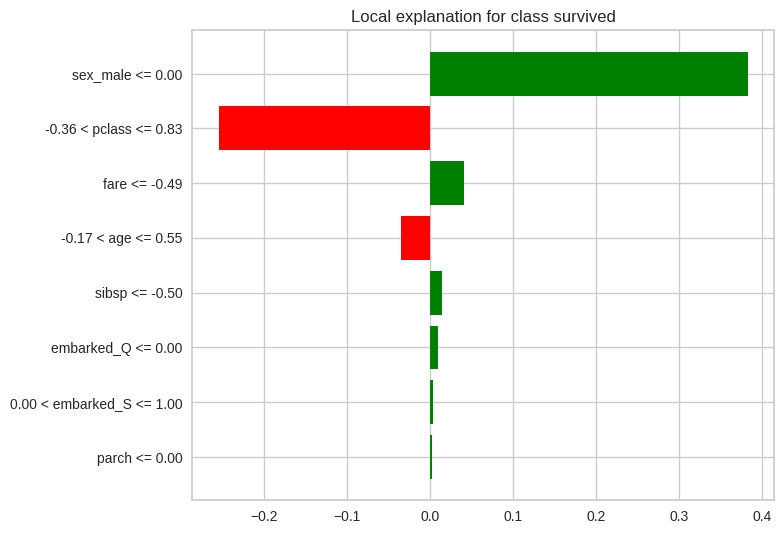

In [6]:
fig = exp.as_pyplot_figure()
fig.tight_layout()

In [7]:
from treeinterpreter import treeinterpreter as ti
from sklearn.ensemble import RandomForestClassifier

In [8]:
rf5 = RandomForestClassifier(
    **{
        "min_samples_leaf": 0.1,
        "n_estimators": 200,
        "random_state": 42
    }
)

In [9]:
rf5.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=0.1, n_estimators=200, random_state=42)

In [10]:
instances = X.iloc[:2]
prediction, bias, contribs = ti.predict(
    rf5, instances
)

/home/pcmoraes/anaconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/pcmoraes/anaconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/pcmoraes/anaconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/pcmoraes/anaconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/pcmoraes/anaconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/pcmoraes/anaconda3/lib/python3.11/site-packages/sklearn/base.py:

/home/pcmoraes/anaconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/pcmoraes/anaconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/pcmoraes/anaconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/pcmoraes/anaconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/pcmoraes/anaconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/pcmoraes/anaconda3/lib/python3.11/site-packages/sklearn/base.py:

In [11]:
i = 0
print("Instance", i)
print("Prediction:", prediction[i])
print("Bias (trainset mean)", bias[i])
print("Feature contributions:")
for c, feature in zip(contribs[i], instances.columns):
    print(" {} {}".format(feature, c))

Instance 0
Prediction: [0.82046191 0.17953809]
Bias (trainset mean) [0.63887555 0.36112445]
Feature contributions:
 pclass [ 0.02865085 -0.02865085]
 age [ 0.01115629 -0.01115629]
 sibsp [ 0.00528926 -0.00528926]
 parch [ 0.00656872 -0.00656872]
 fare [ 0.04126856 -0.04126856]
 sex_male [ 0.07660626 -0.07660626]
 embarked_Q [0. 0.]
 embarked_S [ 0.01204643 -0.01204643]


In [12]:
from pdpbox import pdp
import pdpbox

In [13]:
import matplotlib.font_manager

font_list = matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

for font_path in font_list:
    print(font_path)


/usr/share/fonts/truetype/kacst/KacstTitleL.ttf
/usr/share/fonts/opentype/font-awesome/FontAwesome.otf
/usr/share/fonts/truetype/tlwg/Norasi-Italic.ttf
/usr/share/fonts/truetype/lato/Lato-BoldItalic.ttf
/usr/share/fonts/opentype/urw-base35/C059-Bold.otf
/usr/share/fonts/truetype/lato/Lato-BlackItalic.ttf
/usr/share/fonts/opentype/urw-base35/C059-BdIta.otf
/usr/share/fonts/truetype/Navilu/Navilu.ttf
/usr/share/fonts/truetype/tlwg/Waree-BoldOblique.ttf
/usr/share/fonts/truetype/Gubbi/Gubbi.ttf
/usr/share/fonts/opentype/urw-base35/NimbusSans-Bold.otf
/usr/share/fonts/truetype/tlwg/TlwgTypo-Bold.ttf
/usr/share/fonts/truetype/fonts-gujr-extra/padmaa-Bold.1.1.ttf
/usr/share/fonts/truetype/tlwg/TlwgMono-Oblique.ttf
/usr/share/fonts/truetype/tlwg/Umpush-Light.ttf
/home/pcmoraes/anaconda3/fonts/SourceCodePro-Bold.ttf
/usr/share/fonts/truetype/malayalam/Uroob-Regular.ttf
/usr/share/fonts/truetype/tlwg/Norasi-BoldOblique.ttf
/usr/share/fonts/truetype/lato/Lato-LightItalic.ttf
/usr/share/fonts/tru

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

findfont: Font family 'Arial' not found.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


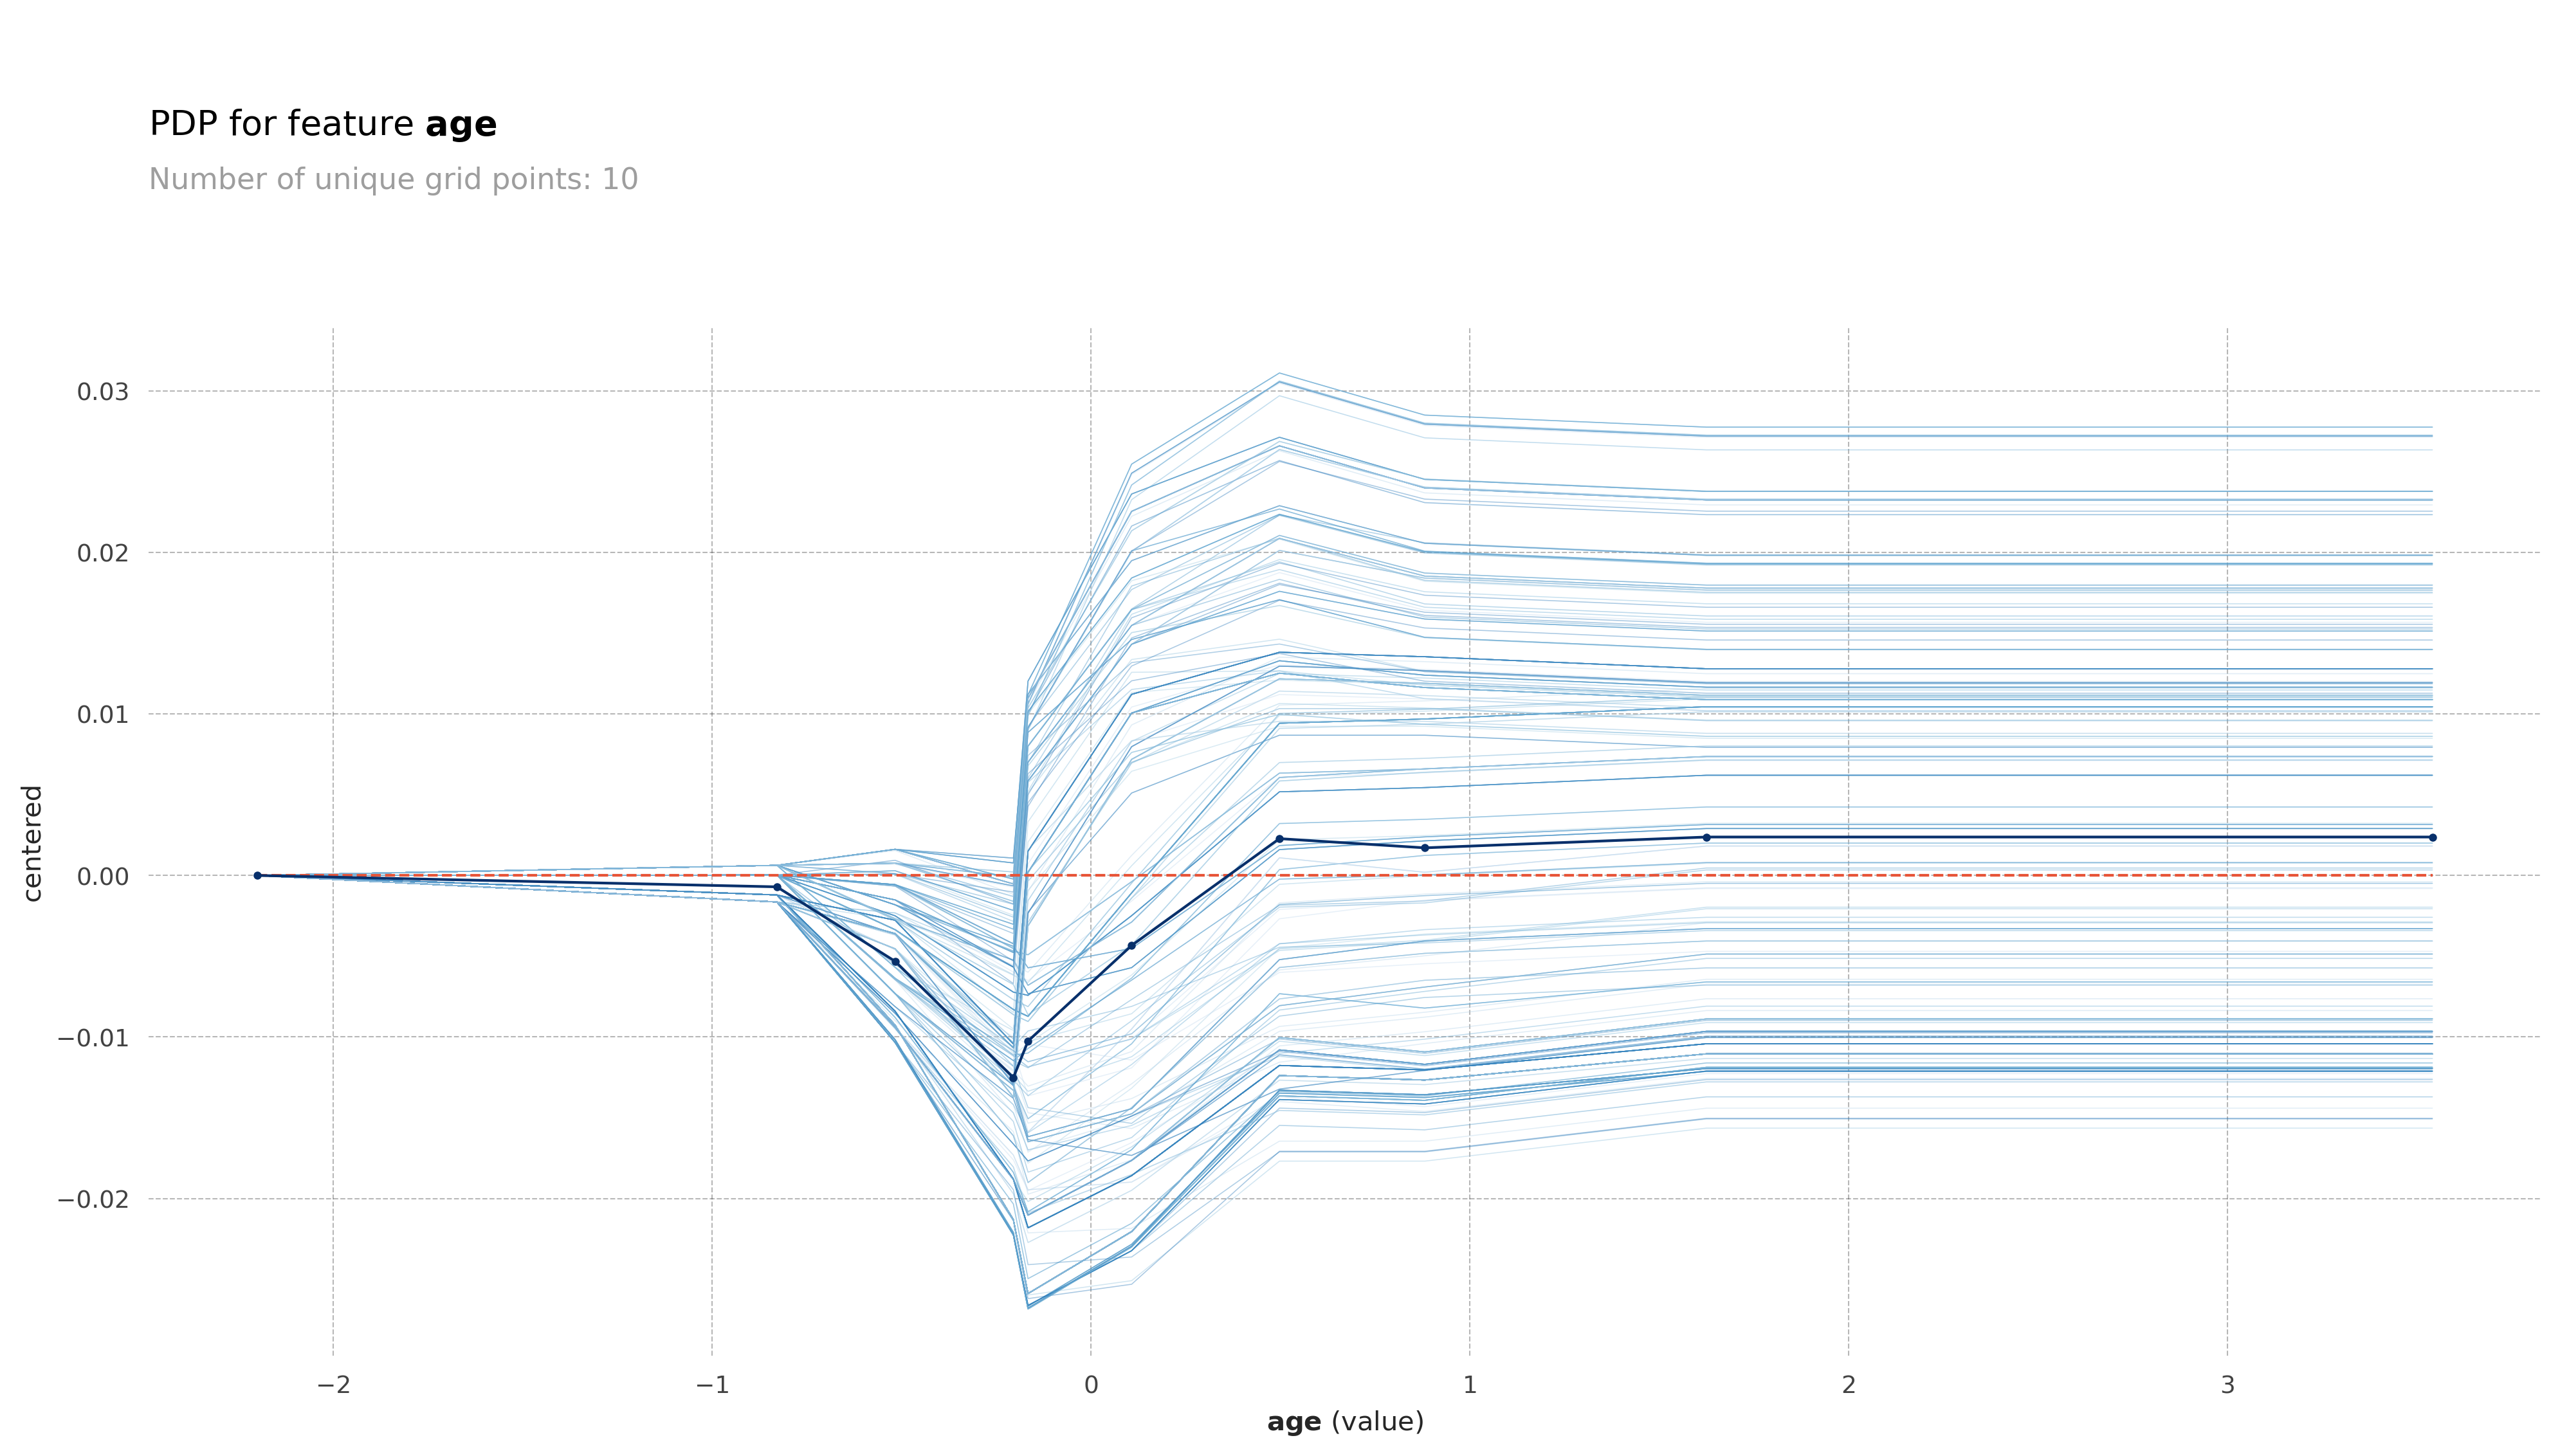

In [14]:
feat_name = "age"

# Make sure feature names match those used during model training
model_features = X.columns

# Create the PDPIsolate instance
pdp_isolate_out = pdp.PDPIsolate(
    model=rf5,
    df=X_test,
    model_features=model_features,  # Ensure model features match
    feature=feat_name,
    feature_name=feat_name,
)


plt.rcParams['font.family'] = 'DejaVu Sans'
figure, axes = pdp_isolate_out.plot(engine="matplotlib", plot_lines=True)


plt.show()

In [15]:
from sklearn import svm

In [16]:
sv = svm.SVC()

In [17]:
sv.fit(X_train, y_train)

SVC()

In [18]:
sur_dt = tree.DecisionTreeClassifier()
sur_dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [19]:
for col, val in sorted(
    zip(
        X_test.columns,
        sur_dt.feature_importances_
    ),
    key=lambda x: x[1],
    reverse=True
)[:5]:
    print(col, val)

age 0.2869144673517636
sex_male 0.2838783984216829
fare 0.23427981526291997
pclass 0.11577406040980462
sibsp 0.04613384045758187


In [29]:
import shap
shap.initjs()


In [30]:
s = shap.TreeExplainer(rf5)

In [33]:
shap_vals = s.shap_values(X_test)
target_idx = 1

shap.force_plot(
    s.expected_value[target_idx],
    shap_vals[target_idx][20,:],
    feature_names=X_test.columns,    
)

In [37]:
shap.force_plot(
    s.expected_value[1],
    shap_vals[1],
    feature_names=X_test.columns,)

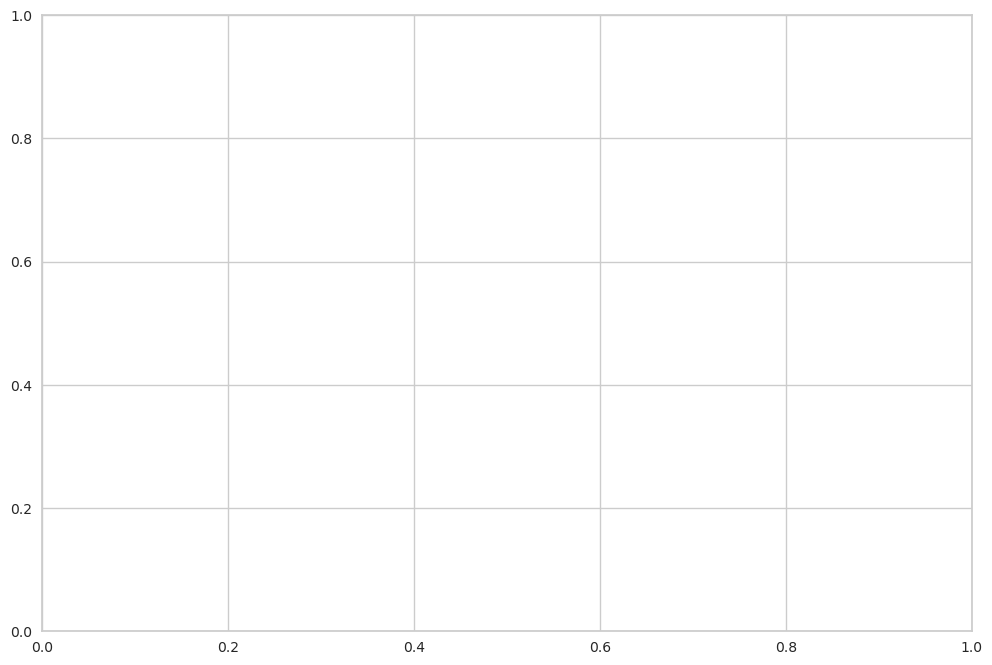

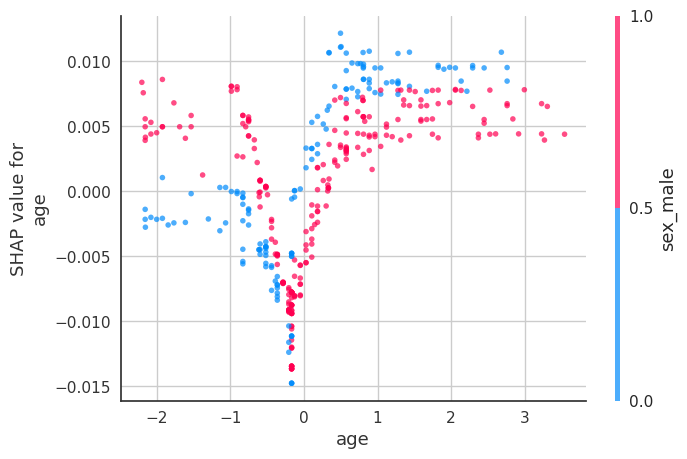

In [38]:
fig, ax = plt.subplots(figsize=(12, 8))
res = shap.dependence_plot(
    "age",
    shap_vals[target_idx],
    X_test,
    feature_names=X_test.columns,
    alpha=0.7,
)

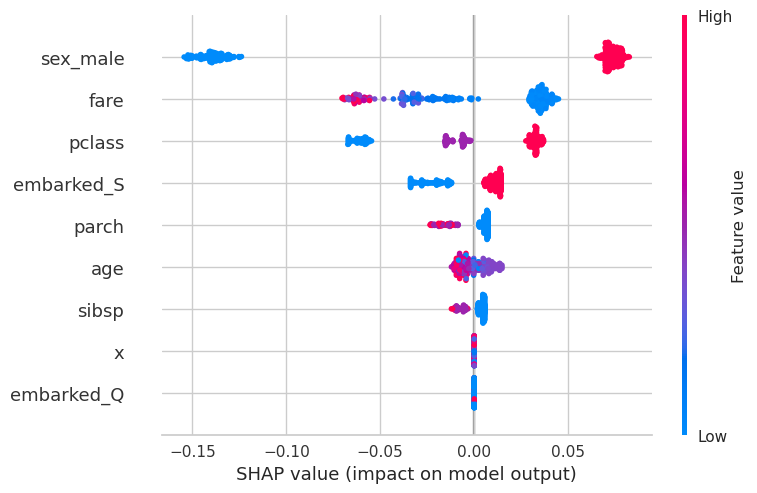

In [39]:
fig, ax = plt.subplots(figsize=(12, 8))
shap.summary_plot(
    shap_vals[0], X_test
)